In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Step 1: Data Collection


In [25]:
# Define the stock universe (e.g., S&P 500 constituents)
# For demonstration, we'll use a sample list of tickers
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

# Limit to the first 100 tickers for brevity
#tickers = tickers[:100]

# Define the time period
start_date = '2018-01-01'
end_date = '2023-01-01'

# Download historical price data
price_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Download market capitalization data (size)
# Since yfinance does not provide market cap, we'll simulate size using average price
# In practice, use a reliable data source for market cap
market_cap_data = price_data.mean()

[*********************100%***********************]  503 of 503 completed

8 Failed downloads:
['AMTM', 'SW', 'GEV', 'SOLV', 'VLTO', 'KVUE']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2023-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1514782800, endDate = 1672549200")')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2023-01-01)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


## Step 2: Data Preprocessing


In [35]:
# Calculate daily returns
returns = price_data.pct_change().dropna(how='all')

# Simulate analyst ratings as the alpha signal
# For demonstration, generate random ratings influenced by size
np.random.seed(42)
alpha_signal = pd.DataFrame(index=price_data.index, columns=price_data.columns)
for ticker in tickers:
    size_effect = np.log(market_cap_data[ticker])
    alpha_signal[ticker] = np.random.normal(loc=size_effect, scale=1, size=len(price_data))

# Align returns and alpha_signal
alpha_signal = alpha_signal.loc[returns.index]

/tmp/ipykernel_36658/1275702346.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = price_data.pct_change().dropna(how='all')


## Step 3: Exploratory Data Analysis


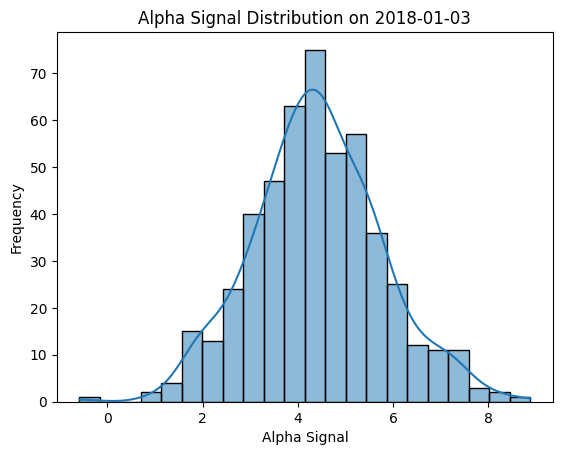

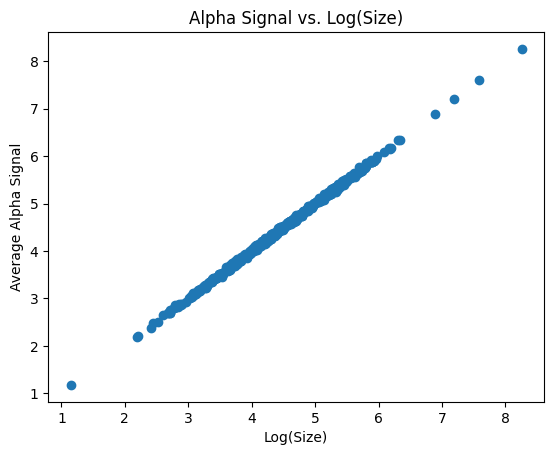

In [37]:
# Plot the distribution of the alpha signal for a sample date
sample_date = alpha_signal.index[0]
sns.histplot(alpha_signal.loc[sample_date].dropna(), kde=True)
plt.title(f'Alpha Signal Distribution on {sample_date.date()}')
plt.xlabel('Alpha Signal')
plt.ylabel('Frequency')
plt.show()

# Analyze the relationship between alpha signal and size
size_log = np.log(market_cap_data)
alpha_mean = alpha_signal.mean()
plt.scatter(size_log, alpha_mean)
plt.title('Alpha Signal vs. Log(Size)')
plt.xlabel('Log(Size)')
plt.ylabel('Average Alpha Signal')
plt.show()

## Step 4: Quantile Regression Implementation


In [38]:
# Prepare the data for regression
# Flatten the DataFrame for regression analysis
data = alpha_signal.stack().reset_index()
data.columns = ['Date', 'Ticker', 'Alpha_Signal']

# Add size as a factor
data['Size'] = data['Ticker'].map(market_cap_data)
data['Log_Size'] = np.log(data['Size'])

# Perform quantile regression for selected quantiles
quantiles = [0.1, 0.5, 0.9]
models = {}
for q in quantiles:
    model = QuantReg(data['Alpha_Signal'], data[['Log_Size']])
    res = model.fit(q=q)
    models[q] = res
    print(f'Quantile {q}:')
    print(res.summary())

# Obtain residuals (adjusted alpha signal)
# We'll use the median (0.5 quantile) regression for adjustment
median_model = models[0.5]
data['Adjusted_Alpha_Signal'] = data['Alpha_Signal'] - median_model.predict(data[['Log_Size']])

# Reshape the adjusted alpha signal back to original format
adjusted_alpha_signal = data.pivot(index='Date', columns='Ticker', values='Adjusted_Alpha_Signal')

Quantile 0.1:
                         QuantReg Regression Results                          
Dep. Variable:           Alpha_Signal   Pseudo R-squared:               0.2170
Model:                       QuantReg   Bandwidth:                     0.04793
Method:                 Least Squares   Sparsity:                        5.517
Date:                Sat, 12 Oct 2024   No. Observations:               622710
Time:                        13:16:39   Df Residuals:                   622709
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Log_Size       0.7123      0.000   1584.077      0.000       0.711       0.713
Quantile 0.5:
                         QuantReg Regression Results                          
Dep. Variable:           Alpha_Signal   Pseudo R-squared:               0.2413
Model:                  

## Step 5: Evaluation of Adjusted Alpha Signal


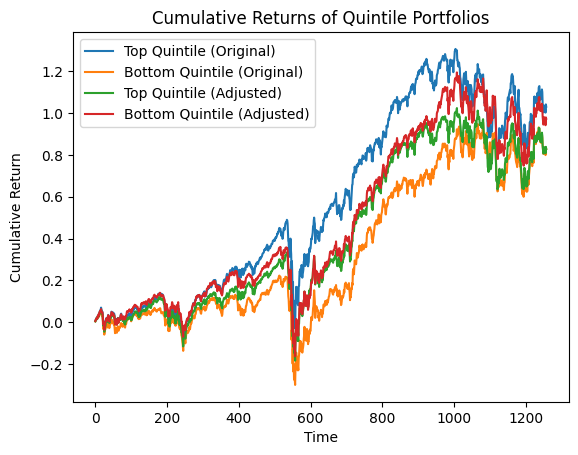

Average Size by Quintile (Original Alpha Signal):
{0: 48.706739668141346, 1: 76.63448246195411, 2: 102.54367382825647, 3: 136.67683709568539, 4: 270.39266607298777}
Average Size by Quintile (Adjusted Alpha Signal):
{0: 126.9349536568682, 1: 126.4445558494181, 2: 126.80313285527659, 3: 127.07941347436812, 4: 127.69234329109405}


In [40]:

# Define a function to create quintile portfolios and calculate returns
def calculate_portfolio_returns(alpha_signal, returns):
    # For each date, rank stocks into quintiles based on alpha signal
    quintile_returns = {}
    for date in alpha_signal.index:
        ranked = alpha_signal.loc[date].dropna().rank(method='first')
        total = len(ranked)
        quintiles = pd.qcut(ranked, 5, labels=False)
        date_returns = returns.loc[date]
        for q in range(5):
            tickers_in_quintile = quintiles[quintiles == q].index
            if tickers_in_quintile.empty:
                continue
            quintile_returns.setdefault(q, []).append(date_returns[tickers_in_quintile].mean())
    # Calculate cumulative returns
    cumulative_returns = {}
    for q in range(5):
        returns_series = pd.Series(quintile_returns.get(q, [0]))
        cumulative_returns[q] = (1 + returns_series).cumprod() - 1
    return cumulative_returns

# Calculate portfolio returns using original alpha signal
original_portfolios = calculate_portfolio_returns(alpha_signal, returns)

# Calculate portfolio returns using adjusted alpha signal
adjusted_portfolios = calculate_portfolio_returns(adjusted_alpha_signal, returns)

# Plot cumulative returns for top and bottom quintiles
plt.plot(original_portfolios[4], label='Top Quintile (Original)')
plt.plot(original_portfolios[0], label='Bottom Quintile (Original)')
plt.plot(adjusted_portfolios[4], label='Top Quintile (Adjusted)')
plt.plot(adjusted_portfolios[0], label='Bottom Quintile (Adjusted)')
plt.legend()
plt.title('Cumulative Returns of Quintile Portfolios')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.show()

# Analyze factor exposures (e.g., size) before and after adjustment
# For simplicity, we'll calculate the average size of stocks in top and bottom quintiles
def average_size_by_quintile(alpha_signal, market_cap_data):
    size_by_quintile = {}
    for date in alpha_signal.index:
        ranked = alpha_signal.loc[date].dropna().rank(method='first')
        quintiles = pd.qcut(ranked, 5, labels=False)
        for q in range(5):
            tickers_in_quintile = quintiles[quintiles == q].index
            avg_size = market_cap_data[tickers_in_quintile].mean()
            size_by_quintile.setdefault(q, []).append(avg_size)
    avg_sizes = {q: np.mean(sizes) for q, sizes in size_by_quintile.items()}
    return avg_sizes

original_sizes = average_size_by_quintile(alpha_signal, market_cap_data)
adjusted_sizes = average_size_by_quintile(adjusted_alpha_signal, market_cap_data)

print('Average Size by Quintile (Original Alpha Signal):')
print(original_sizes)
print('Average Size by Quintile (Adjusted Alpha Signal):')
print(adjusted_sizes)